In [7]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90       982
           1       0.02      0.17      0.03        18

    accuracy                           0.82      1000
   macro avg       0.50      0.50      0.47      1000
weighted avg       0.96      0.82      0.89      1000

ROC AUC: 0.46961982348947723


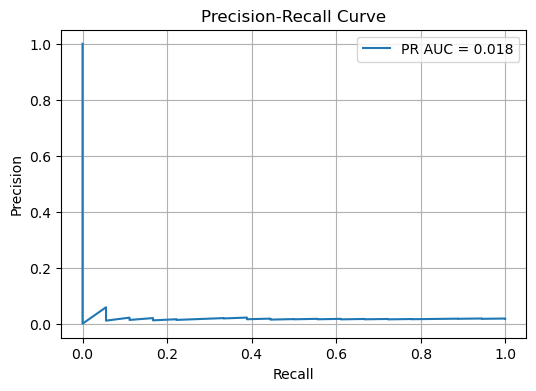

In [13]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

# 2. Load data
df = pd.read_csv("synth_rare_event_data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
target_col = "rare_event"

# 3. Preprocessing
df = df.dropna(subset=[target_col])
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# 4. Mutual Information Feature Selection
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
top_features = mi_series.head(15).index.tolist()
X = X[top_features]

# 5. SMOTE Oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 6. Stacked Classifier with Calibrated Logistic Regression
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42))
]
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5)

stacked_model.fit(X_train_bal, y_train_bal)

# 7. Evaluation
y_pred = stacked_model.predict(X_test)
y_prob = stacked_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# 8. PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()